In [1]:
import math
import io
import torch
from torchvision import transforms
import numpy as np
import pickle
import re
import scipy.stats as st
import PIL
from collections import Counter
from PIL import Image
from PIL import ImageChops
import imageio
from pytorch_msssim import ssim, ms_ssim
import matplotlib.pyplot as plt
from statistics import mean
import compressai
import skimage
import torch.nn.functional as F
from compression import rates
from quality import psnr
from compression import rates
from oligochecker import size
from oligoanalyzer import gc_stats
from oligoanalyzer import homopolymer_stats
from IQA_pytorch import NLPD, VIF, FSIM
import pyiqa
import skimage
import random
import pandas as pd
import matplotlib.patches as patches
import os

In [2]:
from compressai.zoo import bmshj2018_factorized
from compressai.dna_entropy_coding.coder import Coder
from ipywidgets import interact, widgets

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
JPEG_SIZES = [
    '1192x832', 
    '853x945', 
    '945x840', 
    '2000x2496', 
    '560x888',
    '2048x1536', 
    '1600x1200', 
    '1430x1834', 
    '2048x1536', 
    '2592x1946'  
]

In [5]:
DATA_SET_LIST = [
    'kodak', 
    'jpeg_dna'
]

In [6]:
METRICS_LIST = [
    'PSNR', 
    'PSNR-YUV', 
    #'PSNR-Y-CB-CR', 
    'MS-SSIM', 
    'IW-SSIM', 
    'NLPD', 
    'VIF', 
    'FSIM',
    'VMAF', 
    'Homopolymer density', 
    'Homopolymer average length', 
    'Homopolymer frequency'
]

In [7]:
MODELS_LIST = [
    'benchmarkcodec', 
    'anchor1', 
    'anchor3', 
    'learningbased', 
    'BCtranscoder'
]

### Image extraction

In [8]:
def get_original_tensor(data_set, img_id): 
    path = get_original_image_path(data_set, img_id)
    img = Image.open(path).convert('RGB')
    x = transforms.ToTensor()(img).unsqueeze(0).to(device)
    return img, x

In [9]:
def get_original_image_path(data_set, img_number): 
    img_path = 'assets/' + data_set
    if data_set == 'kodak':
        img_name = '/kodim{:02d}.png'.format(img_number)
        
    if data_set == 'jpeg_dna': 
        img_name = f"/{str(img_number).zfill(5)}_" + JPEG_SIZES[img_number-1]+'.png'
    return img_path + img_name

In [10]:
def get_decoded_image_path(data_set, model_name, img_number, quality): 
    path = 'assets/' + data_set +'/' + model_name
    img_name = ''
    if data_set == 'kodak': 
        img_name = '/{}kodim{:02d}.png'.format(quality, img_number)
        
    elif data_set == 'jpeg_dna':
        img_name = f"/JPEG-1_{str(img_number).zfill(5)}" + '_' + JPEG_SIZES[img_number-1] + '_' + str(quality) + '_decoded' + '.png'
    else : 
        return ''
    return path + img_name

In [11]:
def get_decoded_tensor(data_set, model_name, img_number, quality):
    path = get_decoded_image_path(data_set, model_name, img_number, quality)
    img = Image.open(path).convert('RGB')   
    x = transforms.ToTensor()(img).unsqueeze(0).to(device)
    return img, x

In [12]:
def get_dna_path(data_set, model_name, img_number, quality): 
    path = 'assets/' + data_set +'/' + model_name
    dna_name = ''
    if data_set == 'kodak': 
        dna_name = '/{}kodim{:02d}.fasta'.format(quality, img_number)
        
    elif data_set == 'jpeg_dna':
        dna_name = f"/JPEG-1_{str(img_number).zfill(5)}" + '_' + JPEG_SIZES[img_number-1] + '_' + str(quality) + '.fasta'
    else : 
        return ''
    return path + dna_name

In [13]:
def get_dna(data_set, model_name, img_number, quality):
    path = get_dna_path(data_set, model_name, img_number, quality)
    fasta_file = open(path)
    dna = fasta_file.read()
    fasta_file.close()
    return dna


In [14]:
def compute_bit_rate(img, dna): 
    h, w = img.size
    return len(dna)/(h*w)

In [15]:
def print_model(model_name): 
    if model_name == 'anchor1': 
        return 'Anchor 1'
    elif model_name == 'anchor3': 
        return 'Anchor 3'
    elif model_name == 'benchmarkcodec': 
        return 'JPEG DNA Benchmark Codec'
    elif model_name == 'BCtranscoder': 
        return 'JPEG DNA BC Transcoder'
    elif model_name == 'learningbased': 
        return 'Learning based'
    else : return ''

In [16]:
#print(get_dna('jpeg_dna', 'anchor1', 1, 1))#

# Biochemical constraints

### DNA CG contents

In [17]:
def CG_content(dna) : 
    return 100*(dna.count("C")+dna.count("G"))/len(dna)

In [18]:
for i in range(1,9): 
    dna = get_dna('jpeg_dna', 'learningbased', 1, i)
    print(CG_content(dna))

71.03116994022203
69.95794858875851
70.34485259455343
70.34880992551838
69.9221645068868
72.79724524869629
71.40989945922975
69.49046843579059


In [19]:
def plot_cg_contents(model_name, data_set = 'jpeg_dna'): 
    """
    Plots of the percentage of CG nucleotides in dna strands in regards of the quality of the 
    encoding, computed for the 24 images of the kodak data set.  
    
    Parameters
    ----------
    model_name: string 
        name of the model to be used for dna encoding
        'anchor1', 'anchor3', 'benchmark codec', 'BC transcoder' or 'learning based'
        
    Returns
    -------
    A plot saved in the folder plots/
    """
    if data_set == 'kodak': 
        number_of_images = 24
    elif data_set == 'jpeg_dna': 
        number_of_images = 10
    else : 
        print("Ivalid data set name, please enter  'jpeg_dna' or 'kodak'.")
        return
    
    
    for i in range(1, number_of_images+1): 
        cg = []
        bit_rate = []
        #print('image' + str(i))
        for q in range(1,8):
            if (data_set == 'jpeg_dna') and (model_name == 'anchor1') and (q == 1) and (i >= 6): 
                break
            else : 
                #print ('quality' + str(q))
                dna = get_dna(data_set, model_name, i, q)
                img, x = get_decoded_tensor(data_set, model_name, i, q)
                cg.append(CG_content(dna))
                bit_rate.append(compute_bit_rate(img, dna))
            
        plt.plot(bit_rate, cg)
    
    
    plt.xlabel('Rate (nt/pxl)')
    plt.ylabel('CG content (%)')
    #plt.title('CG contents of the ' + print_model(model_name) +' DNA for all the images of the ' + data_set + ' data set')
    plt.ylim(0, 100) 
    plt.savefig('plots/rapport/cg_' + data_set + '_'+ model_name + '.jpeg', bbox_inches='tight')
    plt.show()
    
def plot_all_cg_contents(): 
    for model_name in MODELS_LIST: 
        for data_set in DATA_SET_LIST: 
            plot_cg_contents(model_name, data_set)
        

In [20]:
#plot_all_cg_contents()

### Homopolymers

In [21]:
def count_homopolymers(homopolymer_list, bases_counter, dna_substrand, i):
    """
    Recursively counts the homopolymers in a dna strand
    
    Parameters:
    ----------
        homopolymer_list : list<int>
            list of the length of the homopolymers in the strand
        bases_counter : int
            counter for the number of bases in the homopolymer
        dna_substrand : string
            studied dna strand
        i : int 
            index of the bases in the dna
                                    
    Returns:
    ----------
        The list of the lengths of the homopolymers in the given DNA substrand 
    """
   # Check if we have reached the end of the dna_substrand or if there are less than two bases in the current substring
    if i == 1 or i == 0 or i >= len(dna_substrand):
        # If true, return the homopolymer_list
        return homopolymer_list 
    # Check if the current base is identical to the previous one
    elif dna_substrand[i] == dna_substrand[i-1] : 
        # If true, increment the bases_counter and continue recursively checking the previous base
        return count_homopolymers(homopolymer_list, bases_counter+1, dna_substrand, i-1)
    # Check if we have found a homopolymer
    elif bases_counter >= 7 : 
        # If true, append the length of the homopolymer to the homopolymer_list and reset the bases_counter to 0. 
        # Continue recursively checking the previous base
        homopolymer_list.append(bases_counter+1)
        return count_homopolymers(homopolymer_list, 0, dna_substrand, i-1)
    else : 
        # If none of the above conditions are met, reset the bases_counter to 0 and continue recursively checking the previous base
        return count_homopolymers(homopolymer_list, 0, dna_substrand, i-1)


In [22]:

def check_homopolymers(dna, max_recursion_depth=2000):
    """
    Takes a DNA sequence and calculates the homopolymers present in it.
    
    Parameters:
    ----------
        dna : string
            The DNA sequence to check for homopolymers
        max_recursion_depth : int
            The maximum recursion depth to be used for checking homopolymers.
            Default is set to 2970.
                                   
    Returns:
    ----------
        A tuple containing:
        - The number of homopolymers found
        - A list of homopolymers found
        - The average length of homopolymers found
        - The density of homopolymers found
        
    """
    count = 0 # counter for homopolymers
    homopolymer_list = [] # list to store homopolymers
    avg_len = 0 # variable to store average length of homopolymers
    homopolymer_density = 0 # variable to store density of homopolymers
    homopolymer_frequency = 0 # variable to store frequency of homopolymers
    
    # Check if the length of the DNA exceeds the recursion depth
    if len(dna) > max_recursion_depth: 
        # Iterate over the sub-strands of an acceptable length
        for i in range(0, len(dna)-1, max_recursion_depth):
            # Get the end index of the sub-strand
            end_index = min(i+max_recursion_depth, len(dna)-1)
            dna_substrand = dna[i:end_index]
            # Count homopolymers in the sub-strand
            homo_in_substrand = count_homopolymers([], 0, dna_substrand, len(dna_substrand)-1)
            if  len(homo_in_substrand)!=0:
                homopolymer_list.extend(homo_in_substrand)
    else: 
        # Count homopolymers in the DNA sequence
        homopolymer_list = count_homopolymers([], 0, dna, len(dna)-1)
        
    if len(homopolymer_list) != 0: 
        # Calculate average length and density of homopolymers
        avg_len = mean(homopolymer_list)
        homopolymer_density = ((avg_len * len(homopolymer_list))/len(dna))*100
        homopolymer_frequency = 1000*len(homopolymer_list)/len(dna)
    
    # Print the results
    #print("List of homopolymers: ", homopolymer_list)
    #print("Average length of the homopolymers : ", avg_len)
    #print("Density of the homopolymers : ", homopolymer_density, " %")
    
    # Return the results as a tuple
    return len(homopolymer_list), homopolymer_list, avg_len, homopolymer_density, homopolymer_frequency


In [23]:
def compute_homopolymer_data(dna, data_name): 
    nbr_homopolymer, homopolymer_list, avg_len, homopolymer_density, homopolymer_frequency  = check_homopolymers(dna)
    if data_name == 'Homopolymer density': 
        return homopolymer_density
    elif data_name == 'counter': 
        return nbr_homopolymer
    elif data_name == 'Homopolymer average length': 
        return avg_len
    elif data_name == 'Homopolymer frequency':
        return homopolymer_frequency
    else : 
        print('Invalid dna data name')
        return

In [76]:
def plot_homopolymers(data_set, model_name, img_number):
    
    """
    Plots the distribution of homopolymer length in the DNA generated by the model for 
    the given image,at different rates. Each bar represents the number of homopolymer 
    at given length, each color represents the encoding rate.

    Parameters
    ----------
    data_set: string 
        name of the dataset from which DNA is analyzed
        'kodak' or 'jpeg_dna'   
    model_name: string 
        name of the model to be used for dna encoding
        'anchor1', 'anchor3', 'benchmark codec', 'BC transcoder' or 'learning based'
    img_number: int
        number of the image in the data set
        

    Returns
    -------
    The plot saved in the folder /plots/homopolymers/
    """
    
    if (data_set == 'kodak' and img_number not in [1,24]) or (data_set == 'jpeg_dna' and img_number not in [1,10]) : 
        print("Invalid image number for ", data_set, " dataset.")
        return
        
        
    width = 0.8
    fig, ax = plt.subplots()

    # Get homopolymer lengths for each quality level and store in a list
    homopolymer_length_lists = []
    for quality in range(1, 9):
        dna = get_dna(data_set, model_name, img_number, quality)
        _, homopolymer_lengths, _, _ = check_homopolymers(dna)
        homopolymer_length_lists.append(homopolymer_lengths)

    # Determine max homopolymer length across all lists
    max_lengths = [max(l) for l in homopolymer_length_lists if len(l) > 0]
    max_length = max(max_lengths) if len(max_lengths) > 0 else 99
    print(max_length)

    # Compute counts for each homopolymer length across all lists
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
    bottom = np.zeros(max_length)

    for i, length_list in enumerate(homopolymer_length_lists):
        counts = [0] * max_length
        for length in length_list:
            if length <= max_length:
                counts[length-1] += 1
        p = ax.bar(range(1, max_length+1), counts, width, label='Quality '+str(i+1), bottom=bottom, color=colors[i])
        bottom += counts

    #ax.set_title('Distribution of Homopolymer lengths for the image '+ str(img_number) + ' of the ' + data_set + ' data set, using the ' +  print_model(model_name) + ' model')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    ax.set_xlabel('Homopolymer Length')
    ax.set_ylabel('Number of Homopolymers')
    plt.savefig('plots/homopolymers/'+ data_set + '_'+model_name +'_im' + str(img_number) +'.png', bbox_inches='tight')

    plt.show()


In [25]:
#plot_homopolymers('jpeg_dna', 'BCtranscoder', 4)
#plot_homopolymers('jpeg_dna', 'benchmarkcodec', 4)

In [77]:
def plot_model_homopolymers(data_set, model_name):
    """
    Plots the distribution of homopolymer length in all the DNA generated by the model for 
    all the images of the data set, at different rates. Each bar represents the number of homopolymer 
    at given length, each color represents a different image.

    Parameters
    ----------
    data_set: string 
        name of the dataset from which DNA is analyzed
        'kodak' or 'jpeg_dna'   
    model_name: string 
        name of the model to be used for dna encoding
        'anchor1', 'anchor3', 'benchmark codec', 'BC transcoder' or 'learning based'
        

    Returns
    -------
    The plot saved in the folder /plots/homopolymers/
    """
    width = 2
    if 'anchor' in model_name : 
        width = .8
    fig, ax = plt.subplots()
    homopolymer_length_lists = []
    
    if data_set == 'jpeg_dna' : 
        number_of_images = 10
    else : number_of_images = 24
        
    # Get homopolymer lengths for each quality level and store in a list
    for img_number in range(1,number_of_images+1):
        homopolymer_lengths_for_image = []
        for quality in range(1, 9):
            dna = get_dna(data_set, model_name, img_number, quality)
            _, homopolymer_lengths, _, _, _ = check_homopolymers(dna)
            homopolymer_lengths_for_image.extend(homopolymer_lengths)
        homopolymer_length_lists.append(homopolymer_lengths_for_image)

        # Determine max homopolymer length across all lists
        max_lengths = [max(l) for l in homopolymer_length_lists if len(l) > 0]
        max_length = max(max_lengths) if len(max_lengths) > 0 else 99
        # Compute counts for each homopolymer length across all lists
        colors = [random.choice(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']) for _ in range(24)]
        bottom = np.zeros(max_length)

    for i, length_list in enumerate(homopolymer_length_lists):
        counts = [0] * max_length
        for length in length_list:
            if length <= max_length:
                counts[length-1] += 1
        #label='Image '+str(i+1),
        p = ax.bar(range(1, max_length+1), counts, width,  bottom=bottom, color=colors[i])
        bottom += counts

    #ax.set_title('Distribution of Homopolymer lengths for the'+ data_set+ ' data set, using the ' +  print_model(model_name) + ' model')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    ax.set_xlabel('Homopolymer Length')
    ax.set_ylabel('Number of Homopolymers')
    plt.savefig('plots/homopolymers/models/'+ data_set + '_'+model_name+'.png', bbox_inches='tight')

    plt.show()


In [27]:
def plot_all_model_homopolymers(): 
    for data_set in DATA_SET_LIST: 
        for model in MODELS_LIST: 
            plot_model_homopolymers(data_set, model)

In [28]:
#plot_all_model_homopolymers()

In [29]:
#plot_all_model_homopolymers()

In [30]:
def plot_all_homopolymers(): 
    for data_set in DATA_SET_LIST:
        if data_set == 'jpeg_dna': 
            number_of_images = 10
        else : number_of_images = 24
        for model_name in MODELS_LIST: 
            for img_number in range(1, number_of_images+1): 
                plot_homopolymers(data_set, model_name, img_number)

In [31]:
#plot_all_homopolymers()

In [32]:
#plot_homopolymers('kodak', 'BCtranscoder', 1)
#dna = get_dna('kodak', 'BCtranscoder', 1, 1)
#check_homopolymers(dna)


# Objective quality evaluation

In [33]:
def remove_padding(original_tensor, reconstructed_tensor): 
    height = original_tensor.shape[2]
    width = original_tensor.shape[3]
    reconstructed_tensor = reconstructed_tensor[:, :, :height, :width]
    return reconstructed_tensor

## Metrics

#### PSNR


In [34]:
def compute_psnr(original_tensor, reconstructed_tensor):
    reconstructed_tensor = remove_padding(original_tensor, reconstructed_tensor)
    mse = torch.mean((original_tensor - reconstructed_tensor)**2).item()
    return -10 * math.log10(mse)


In [35]:
def compute_psnr_yuv(original_tensor, reconstructed_tensor):
    reconstructed_tensor = remove_padding(original_tensor, reconstructed_tensor)
    reconstructed_img =  transforms.ToPILImage()(reconstructed_tensor.squeeze().cpu())
    original_img = transforms.ToPILImage()(original_tensor.squeeze().cpu())
    original_img = np.array(original_img)
    reconstructed_img = np.array(reconstructed_img)
    return psnr.psnr_yuv(original_img, reconstructed_img)

In [36]:
def compute_psnr_y_cb_cr(original_tensor, reconstructed_tensor): 
    reconstructed_tensor = remove_padding(original_tensor, reconstructed_tensor)
    reconstructed_img =  transforms.ToPILImage()(reconstructed_tensor.squeeze().cpu())
    original_img = transforms.ToPILImage()(original_tensor.squeeze().cpu())
    original_img = np.array(original_img)
    reconstructed_img = np.array(reconstructed_img)
    return psnr.psnr_y_cb_cr(original_img, reconstructed_img)

#### MS-SSIM


In [37]:
def compute_msssim(original_tensor, reconstructed_tensor):
    reconstructed_tensor = remove_padding(original_tensor, reconstructed_tensor)
    return ms_ssim(original_tensor, reconstructed_tensor, data_range=1.).item()

#### IW-SSIM

In [38]:
def compute_iwssim(original_tensor, reconstructed_tensor, k=0.01):
    reconstructed_tensor = remove_padding(original_tensor, reconstructed_tensor)
    # Compute the constants c1 and c2 used in the IW-SSIM formula
    c1 = (k * 1) ** 2
    c2 = (k * 1) ** 2
    # Compute the mean, variance, and covariance of the two input images
    mean_original_tensor = original_tensor.mean(dim=(1, 2, 3), keepdim=True)
    mean_reconstructed_tensor = reconstructed_tensor.mean(dim=(1, 2, 3), keepdim=True)
    var_original_tensor = ((original_tensor - mean_original_tensor) ** 2).mean(dim=(1, 2, 3), keepdim=True)
    var_reconstructed_tensor = ((reconstructed_tensor - mean_reconstructed_tensor) ** 2).mean(dim=(1, 2, 3), keepdim=True)
    cov = ((original_tensor - mean_original_tensor) * (reconstructed_tensor - mean_reconstructed_tensor)).mean(dim=(1, 2, 3), keepdim=True)
    
    # Compute the SSIM value between the two input images using pytorch_msssim's ssim function
    ssim_val = ssim(original_tensor, reconstructed_tensor, data_range=1.0, win_size=11, size_average=True)
    
    # Compute the IW-SSIM value using the mean, variance, covariance, and SSIM values
    iwssim_val = ((2 * mean_original_tensor * mean_reconstructed_tensor + c1) * (2 * cov + c2)) / ((mean_original_tensor ** 2 + mean_reconstructed_tensor ** 2 + c1) * (var_original_tensor + var_reconstructed_tensor + c2)) * ssim_val
    
    # Return the average IW-SSIM value across the batch
    return iwssim_val.mean().item()


#### NLPD


In [39]:
def compute_nlpd(original_tensor, reconstructed_tensor):
    reconstructed_tensor = remove_padding(original_tensor, reconstructed_tensor)
    D = NLPD()
    # set requires_grad attribute to True
    reconstructed_tensor.requires_grad = True  
    score = D(reconstructed_tensor, original_tensor, as_loss=False) 
    score_num = score.item()
    # set 'as_loss=True' to get a value as loss for optimizations.
    loss = D(reconstructed_tensor, original_tensor)
    loss.backward()
    return score_num

#### VIF


In [40]:
def compute_vif(original_tensor, reconstructed_tensor):
    D = VIF()
    reconstructed_tensor = remove_padding(original_tensor, reconstructed_tensor)
    # set requires_grad attribute to True
    reconstructed_tensor.requires_grad = True  
    score = D(reconstructed_tensor, original_tensor, as_loss=False)
    score_num = score.item()
    # set 'as_loss=True' to get a value as loss for optimizations.
    loss = D(reconstructed_tensor, original_tensor)
    loss.backward()
    return score_num

#### FSIM

In [41]:
def compute_fsim(original_tensor, reconstructed_tensor): 
    iqa_metric = pyiqa.create_metric('fsim', device=device)
    reconstructed_tensor = remove_padding(original_tensor, reconstructed_tensor)
    score_fr = iqa_metric(original_tensor, reconstructed_tensor)
    #score_nr = iqa_metric(img_tensor_x)
    return score_fr.item()

#### VMAF

In [42]:
def get_vmaf(data_set, model_name, img_id, quality):
    # Load the Excel table into a pandas DataFrame
    df = pd.read_excel('/Users/noemiemonnier/Documents/COURS/pds/CompressAI_pds/VMAF/' + model_name + '_' + data_set + '_vmaf.xlsx')

    # Filter the DataFrame based on the specified parameters
    filtered_df = df[
        (df['Image'] == img_id) &
        (df['Quality'] == quality)
    ]

    # Check if any rows match the filter
    if len(filtered_df) > 0:
        # Retrieve the VMAF value from the first matching row
        vmaf_value = filtered_df.iloc[0]['VMAF']
        return vmaf_value
    else:
        return None

### Plots

In [43]:
def compute_metric(metric_name, original_tensor, reconstructed_tensor): 
    
    """
    Computes the quality metric given by 'metric_name' for an encoded image, 
    in comparison to an original image. 

    Parameters
    ----------
    metric_name: string 
        name of the metric to be computed.
        'PSNR', 'PSNR-YUV', 'PSNR-Y-CB-CR', 'MS-SSIM', 'IW-SSIM'
        
    original_tensor: tensor
        original image run through the different encoder
    reconstructed_tensor: tensor
        reconstructed image tensor
        

    Returns
    -------
    The computed value of the given quality metric for the specified image
    """
    
    if metric_name == 'PSNR' : 
        return compute_psnr(original_tensor, reconstructed_tensor)
    
    elif metric_name == 'PSNR-YUV':
        return compute_psnr_yuv(original_tensor, reconstructed_tensor)
    
    elif metric_name == 'PSNR-Y-CB-CR':
        compute_psnr_y_cb_cr(original_tensor, reconstructed_tensor)
        
    elif metric_name == 'MS-SSIM': 
        return compute_msssim(original_tensor, reconstructed_tensor)
    
    elif metric_name =='IW-SSIM': 
        return compute_iwssim(original_tensor, reconstructed_tensor)
    
    elif metric_name == 'NLPD': 
        return compute_nlpd(original_tensor, reconstructed_tensor)
    
    elif metric_name == 'VIF': 
        return compute_vif(original_tensor, reconstructed_tensor)
    
    elif metric_name =='FSIM':
        return compute_fsim(original_tensor, reconstructed_tensor)
    else:
        print("Invalid argument : " + metric_name + ".")
        return

In [44]:
def plot_metric(data_set, metric_name, img_number): 
    """
    Plots a quality metric given by metric_name, for a an image encoded by different models.
    
    Parameters
    ----------
    metric_name: string 
        name of the metric to be plotted
        'PSNR', 'PSNR-YUV', 'PSNR-Y-CB-CR' 'MSSSIM', or 'IWSSIM'
    data_set : string
        name of the data set on which to perform the computations
        'jpeg_dna' or 'kodak'
    img_number: 
        number of the image of interest in the given data set

    Returns
    -------
    A plot saved in the folder /plots
    """
    
    # Check if the metric argument is valid
    if (metric_name in METRICS_LIST) & (data_set in DATA_SET_LIST) :
        
        if data_set == 'kodak' : 
            number_of_images = 24
        elif data_set == 'jpeg_dna' : 
            number_of_images = 10
        if (img_number > number_of_images) or (img_number<1): 
            print('Invalid image number')
    # Initialize empty lists to store metrics and bit rates for the image at all quality levels
        learning_based_metric = []
        anchor1_metric = [] 
        anchor3_metric = []
        benchmark_codec_metric = []
        BC_transcoder_metric = []
        learning_based_bitrates = []
        anchor1_bitrates = []
        anchor3_bitrates = []
        benchmark_codec_bitrates = []
        BC_transcoder_bitrates = []
        original_img, original_tensor = get_original_tensor(data_set, img_number)

       # Loop through quality levels 1-8
        for quality in range(1, 9):
            #print(quality)
            # Load image, tensor and dna for the learning-based method and calculate bit rate
            learning_based_img, learning_based_tensor = get_decoded_tensor(data_set, 'learningbased', img_number,quality)
            learning_based_dna = get_dna( data_set, 'learningbased', img_number,quality)
            learning_based_bitrates.append(compute_bit_rate(original_img, learning_based_dna))

            # Load image, tensor and dna for anchor1, calculate bit rate
            anchor1_img, anchor1_tensor = get_decoded_tensor(data_set, 'anchor1', img_number, quality)
            anchor1_dna = get_dna(data_set, 'anchor1', img_number,quality)
            anchor1_bitrates.append(compute_bit_rate(original_img, anchor1_dna))

            # Load image, tensor and dna for anchor3, calculate bit rate
            anchor3_img, anchor3_tensor = get_decoded_tensor(data_set, 'anchor3', img_number, quality)
            anchor3_dna = get_dna(data_set, 'anchor3', img_number, quality)
            anchor3_bitrates.append(compute_bit_rate(original_img, anchor3_dna))

            # Load image, tensor and dna for the JPEG DNA benchmark codec, calculate bit rate
            benchmark_codec_img, benchmark_codec_tensor = get_decoded_tensor(data_set, 'benchmarkcodec', img_number, quality)
            benchmark_codec_dna = get_dna( data_set, 'benchmarkcodec', img_number,quality)
            benchmark_codec_bitrates.append(compute_bit_rate(original_img, benchmark_codec_dna))

            # Load image, tensor and dna for the JPEG DNA BC transcoder, calculate bit rate
            BC_transcoder_img, BC_transcoder_tensor = get_decoded_tensor(data_set, 'BCtranscoder', img_number, quality)
            BC_transcoder_dna = get_dna( data_set, 'BCtranscoder', img_number,quality)
            BC_transcoder_bitrates.append(compute_bit_rate(original_img, BC_transcoder_dna))

            
            # Calculate metric for each model and add to corresponding list 
            if 'Homopolymer' in metric_name: 
                learning_based_metric.append(compute_homopolymer_data(learning_based_dna, metric_name))                
                anchor1_metric.append(compute_homopolymer_data(anchor1_dna, metric_name))
                anchor3_metric.append(compute_homopolymer_data(anchor3_dna, metric_name))
                benchmark_codec_metric.append(compute_homopolymer_data(benchmark_codec_dna, metric_name))
                BC_transcoder_metric.append(compute_homopolymer_data(BC_transcoder_dna, metric_name))
                
            elif metric_name == 'VMAF': 
                learning_based_metric.append(get_vmaf(data_set, 'learningbased', img_number, quality))                
                anchor1_metric.append(get_vmaf(data_set, 'anchor1', img_number, quality))
                anchor3_metric.append(get_vmaf(data_set, 'anchor3', img_number, quality))
                benchmark_codec_metric.append(get_vmaf(data_set, 'benchmarkcodec', img_number, quality))
                BC_transcoder_metric.append(get_vmaf(data_set, 'BCtranscoder', img_number, quality))
                
            else :  
                learning_based_metric.append(compute_metric(metric_name, original_tensor, learning_based_tensor))
                anchor1_metric.append(compute_metric(metric_name, original_tensor, anchor1_tensor))
                anchor3_metric.append(compute_metric(metric_name, original_tensor, anchor3_tensor))
                benchmark_codec_metric.append(compute_metric(metric_name, original_tensor, benchmark_codec_tensor))
                BC_transcoder_metric.append(compute_metric(metric_name, original_tensor, BC_transcoder_tensor))


        # plot results
        if 'PSNR' in metric_name:  
            unit = ' (dB)'
        elif metric_name == 'Homopolymer density': 
            unit = ' (% bases)'
        elif metric_name == 'Homopolymer average length': 
            unit : ' bases'
        else : unit = ''
        plt.plot(learning_based_bitrates, learning_based_metric, label='Learning based', marker='o', markersize=3)
        plt.plot(anchor1_bitrates, anchor1_metric, label='Anchor 1', marker='o', markersize=3)
        plt.plot(anchor3_bitrates, anchor3_metric, label='Anchor 3', marker='o', markersize=3)
        plt.plot(benchmark_codec_bitrates, benchmark_codec_metric, label='JPEG DNA Benchmark Codec', marker='o', markersize=3)
        plt.plot(BC_transcoder_bitrates, BC_transcoder_metric, label='JPEG DNA BC transcoder', marker='o', markersize=3)
        plt.xlabel('Rate (nts/pxl)')
        plt.ylabel(metric_name + unit)
        #plt.title(metric_name +' of the image ' + str(img_number)+ ' of the ' + data_set +  ' set for different models')
        plt.legend()
        plt.savefig('plots/'+ data_set + '_' + metric_name +'im' + str(img_number) +'.png')
        plt.show()
        
    else : 
        print('Invalid data set name or metric name')
        return

In [45]:
#plot_metric('kodak', 'VMAF', 1)

In [46]:
def plot_all_metrics(img_number, data_set = 'jpeg_dna'): 
        for metric in METRICS_LIST: 
            plot_metric(data_set, metric, img_number)
        plot_vmaf(data_set, img_number)
        
def plot_all(data_set = 'jpeg_dna'): 
    if data_set == 'jpeg_dna': 
        number_of_images = 10
    elif data_set == 'kodak': 
        number_of_images = 24   
    for img_id in range(1,number_of_images+1):
        plot_all_metrics(img_id, data_set)

#plot_all()

In [47]:
def plot_avg_metric(metric_name, data_set = 'jpeg_dna'): 
    """
    Plots the average across all the images of the kodak data set of the quality metric 
    given by metric_name. The images are encoded by different models. 
    
    Parameters
    ----------
    metric_name: string 
        name of the metric to be plotted
        'PSNR', 'MSSSIM', or 'IWSSIM'
    data_set : string
        name of the data set on which to perform the computations
        'jpeg_dna' or 'kodak'
    Returns
    -------
    A plot saved in the folder /plots
    """
    
    # Check input
    if (metric_name not in METRICS_LIST) or (data_set not in DATA_SET_LIST): 
        print ('Invalid metric name or data set. ')
        return
        
    if data_set == 'kodak': 
        number_of_images = 24
    elif data_set == 'jpeg_dna': 
        number_of_images = 10

    # Initialize empty lists to store average metrics and bit rates for each anchor type
    learning_based_avg_metrics = []
    anchor1_avg_metrics = []
    anchor3_avg_metrics = []
    benchmark_codec_avg_metrics = []
    BC_transcoder_avg_metrics = []
    
    learning_based_avg_bitrates = []
    anchor1_avg_bitrates = []
    anchor3_avg_bitrates = []
    benchmark_codec_avg_bitrates = []
    BC_transcoder_avg_bitrates = []


    # Loop through quality levels 1-8
    for quality in range(1, 9):
        #print('quality', quality)
        # Initialize empty lists to store metrics and bit rates for all images at the current quality level
        learning_based_metric = []
        anchor1_metric = [] 
        anchor3_metric = []
        benchmark_codec_metric = []
        BC_transcoder_metric = []

        learning_based_bitrates = []
        anchor1_bitrates = []
        anchor3_bitrates = []
        benchmark_codec_bitrates = []
        BC_transcoder_bitrates = []
        
        # Loop through images
        for img_id in range(1, number_of_images+1):
            #print('im', img_id)
            original_img, original_tensor = get_original_tensor(data_set,img_id)

            # Load image, tensor and dna for the learning-based method and calculate bit rate
            learning_based_img, learning_based_tensor = get_decoded_tensor(data_set, 'learningbased', img_id, quality)
            learning_based_dna = get_dna(data_set, 'learningbased', img_id, quality)
            learning_based_bitrates.append(compute_bit_rate(learning_based_img, learning_based_dna))

            # Load image, tensor and dna for anchor1, calculate bit rate
            if (data_set == 'jpeg_dna') and (quality == 1) and (img_id >= 6): 
                break
            else : 
                anchor1_img, anchor1_tensor = get_decoded_tensor(data_set, 'anchor1', img_id, quality)
                anchor1_dna = get_dna(data_set, 'anchor1', img_id, quality)
                anchor1_bitrates.append(compute_bit_rate(anchor1_img, anchor1_dna))

            # Load image, tensor and dna for anchor3, calculate bit rate
            anchor3_img, anchor3_tensor = get_decoded_tensor(data_set, 'anchor3', img_id, quality)
            anchor3_dna = get_dna(data_set, 'anchor3', img_id, quality)
            anchor3_bitrates.append(compute_bit_rate(anchor3_img, anchor3_dna))

            # Load image, tensor and dna for the JPEG DNA benchmark codec, calculate bit rate
            benchmark_codec_img, benchmark_codec_tensor = get_decoded_tensor(data_set, 'benchmarkcodec', img_id, quality)
            benchmark_codec_dna = get_dna(data_set, 'benchmarkcodec', img_id, quality)
            benchmark_codec_bitrates.append(compute_bit_rate(benchmark_codec_img, benchmark_codec_dna))

            # Load image, tensor and dna for the JPEG DNA BC transcoder, calculate bit rate
            BC_transcoder_img, BC_transcoder_tensor = get_decoded_tensor(data_set, 'BCtranscoder', img_id, quality)
            BC_transcoder_dna = get_dna( data_set, 'BCtranscoder', img_id,quality)
            BC_transcoder_bitrates.append(compute_bit_rate(original_img, BC_transcoder_dna))
            
            if 'Homopolymer' in metric_name: 
                learning_based_metric.append(compute_homopolymer_data(learning_based_dna, metric_name))                
                anchor1_metric.append(compute_homopolymer_data(anchor1_dna, metric_name))
                anchor3_metric.append(compute_homopolymer_data(anchor3_dna, metric_name))
                benchmark_codec_metric.append(compute_homopolymer_data(benchmark_codec_dna, metric_name))
                BC_transcoder_metric.append(compute_homopolymer_data(BC_transcoder_dna, metric_name))
                
                    
            elif metric_name == 'VMAF': 
                learning_based_metric.append(get_vmaf(data_set, 'learningbased', img_id, quality))                
                anchor1_metric.append(get_vmaf(data_set, 'anchor1', img_id, quality))
                anchor3_metric.append(get_vmaf(data_set, 'anchor3', img_id, quality))
                benchmark_codec_metric.append(get_vmaf(data_set, 'benchmarkcodec', img_id, quality))
                BC_transcoder_metric.append(get_vmaf(data_set, 'BCtranscoder', img_id, quality))
    
                
            else :  
                learning_based_metric.append(compute_metric(metric_name, original_tensor, learning_based_tensor))
                anchor3_metric.append(compute_metric(metric_name, original_tensor, anchor3_tensor))
                benchmark_codec_metric.append(compute_metric(metric_name, original_tensor, benchmark_codec_tensor))
                BC_transcoder_metric.append(compute_metric(metric_name, original_tensor, BC_transcoder_tensor))
                
                if (data_set == 'jpeg_dna') and (quality == 1) and (img_id >= 6): 
                    break
                else : 
                    anchor1_metric.append(compute_metric(metric_name, original_tensor, anchor1_tensor))

        # Calculate the average bit rate and metric, and add them to the corresponding lists 
        learning_based_avg_bitrates.append(mean(learning_based_bitrates))
        learning_based_avg_metrics.append(mean(learning_based_metric))
        
        anchor1_avg_bitrates.append(mean(anchor1_bitrates))
        anchor1_avg_metrics.append(mean(anchor1_metric))
        
        anchor3_avg_bitrates.append(mean(anchor3_bitrates))
        anchor3_avg_metrics.append(mean(anchor3_metric))
        
        benchmark_codec_avg_bitrates.append(mean(benchmark_codec_bitrates))
        benchmark_codec_avg_metrics.append(mean(benchmark_codec_metric))
        
        BC_transcoder_avg_bitrates.append(mean(BC_transcoder_bitrates))
        BC_transcoder_avg_metrics.append(mean(BC_transcoder_metric))

    # Plot the result
    unit = ''
    if 'PSNR' in metric_name: 
        unit = (' (dB)')
    elif metric_name == 'Homopolymer density': 
            unit = ' (% bases)'
    elif metric_name == 'Homopolymer frequency': 
            unit = ' (#homo/1000 bases)'
    elif metric_name == 'Homopolymer average length': 
            unit : ' bases'
    plt.plot(learning_based_avg_bitrates, learning_based_avg_metrics, label='Learning based', marker='o', markersize=3)
    plt.plot(anchor1_avg_bitrates, anchor1_avg_metrics, label='Anchor 1', marker='o', markersize=3)
    plt.plot(anchor3_avg_bitrates, anchor3_avg_metrics, label='Anchor 3', marker='o', markersize=3)
    plt.plot(benchmark_codec_avg_bitrates, benchmark_codec_avg_metrics, label='JPEG DNA Benchmark Codec', marker='o', markersize=3)
    plt.plot(BC_transcoder_avg_bitrates, BC_transcoder_avg_metrics, label='JPEG DNA BC transcoder', marker='o', markersize=3)
    plt.xlabel('Rate (nts/pxl)')
    plt.ylabel(metric_name + unit)
    #plt.title('Average ' + metric_name +' across the ' + data_set + ' data set for different models')
    plt.legend()
    plt.savefig('plots/avg/avg_'+ data_set + '_' + metric_name +'.png', bbox_inches='tight')
    plt.show()

In [48]:
#plot_avg_metric('VMAF', 'kodak')

In [49]:
def plot_all_avg_metrics(data_set='jpeg_dna'):
    """
    Plots the average metrics across all the images of data set at different quality levels.
    The images are encoded by different models. 
    """
    for metric in METRICS_LIST : 
        plot_avg_metric(metric, data_set)
    

# Subjective quality inspection

### Kodak image 4

In [82]:
img_learningbased, tensor_learningbased = get_decoded_tensor('kodak', 'learningbased', 4, 3)
dna_learningbased = get_dna('kodak', 'learningbased',4, 3)

img_benchmarkcodec, tensor_benchmarkcodec = get_decoded_tensor('kodak', 'benchmarkcodec', 4, 8)
dna_benchmarkcodec = get_dna('kodak', 'benchmarkcodec', 4, 8)

img_bctranscoder, tensor_bctranscoder = get_decoded_tensor('kodak', 'BCtranscoder', 4, 2)
dna_bctranscoder = get_dna('kodak', 'BCtranscoder', 4, 2)

img_anchor1, tensor_anchor1 = get_decoded_tensor('kodak', 'anchor1', 4, 1)
dna_anchor1 = get_dna('kodak', 'anchor1', 4, 1)

img_anchor3, tensor_anchor3 = get_decoded_tensor('kodak', 'anchor3', 4, 1)
dna_anchor3 = get_dna('kodak', 'anchor3', 4, 1)

img_original, tensor_original = get_original_tensor('kodak', 4)

print("Learning based rate : ", compute_bit_rate(img_learningbased, dna_learningbased))
print("Benchmark codec rate : ", compute_bit_rate(img_benchmarkcodec, dna_benchmarkcodec))
print("BC transcoder rate : ", compute_bit_rate(img_bctranscoder, dna_bctranscoder))
print("Anchor 1 rate : ", compute_bit_rate(img_anchor1, dna_anchor1))
print("Anchor 3 rate : ", compute_bit_rate(img_anchor3, dna_anchor3))


Learning based rate :  0.26227569580078125
Benchmark codec rate :  0.326507568359375
BC transcoder rate :  0.2710011800130208
Anchor 1 rate :  0.290557861328125
Anchor 3 rate :  0.2766062418619792


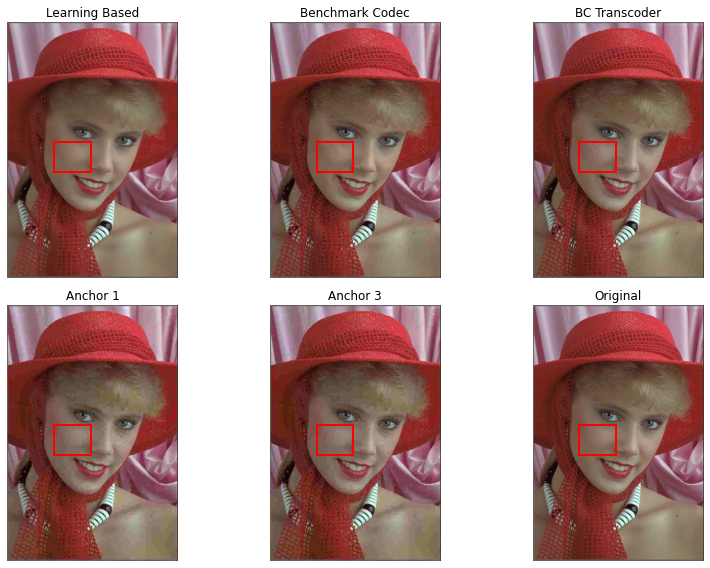

In [83]:
images = [img_learningbased, img_benchmarkcodec, img_bctranscoder, img_anchor1, img_anchor3, img_original]
titles = ['Learning Based', 'Benchmark Codec', 'BC Transcoder', 'Anchor 1', 'Anchor 3', 'Original']
save_folder = '/Users/noemiemonnier/Documents/COURS/pds/CompressAI_pds/examples/assets/subjective eval/skin/box'
box = (140, 360, 250, 449)

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Flatten the axes array to iterate over it easily
axes = axes.flatten()

# Iterate over the images and titles and plot them in the corresponding subplot
for i, (image, title) in enumerate(zip(images, titles)):
    axes[i].imshow(image)
    axes[i].set_title(title)
    axes[i].axis('off')
    
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                             linewidth=2, edgecolor='red', facecolor='none')
    axes[i].add_patch(rect)
    
# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


#plot_metric('kodak', 'PSNR-YUV', 4)
#plot_metric('kodak', 'IW-SSIM', 4)




In [84]:
## SAVES THE IMAGES 

"""
save_folder = '/Users/noemiemonnier/Documents/COURS/pds/CompressAI_pds/examples/assets/subjective eval/skin/box'

for (img, title) in zip(images, titles):
    fig, ax = plt.subplots()  # Create a new figure and axes
    ax.imshow(img)
    ax.axis('off')

    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                             linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)  # Add the rectangle patch to the axes
    save_path = os.path.join(save_folder, f'{title}_box.png')
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    
"""

"\nsave_folder = '/Users/noemiemonnier/Documents/COURS/pds/CompressAI_pds/examples/assets/subjective eval/skin/box'\n\nfor (img, title) in zip(images, titles):\n    fig, ax = plt.subplots()  # Create a new figure and axes\n    ax.imshow(img)\n    ax.axis('off')\n\n    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],\n                             linewidth=2, edgecolor='red', facecolor='none')\n    ax.add_patch(rect)  # Add the rectangle patch to the axes\n    save_path = os.path.join(save_folder, f'{title}_box.png')\n    plt.savefig(save_path, bbox_inches='tight')\n    plt.show()\n    \n"

In [85]:
image_path = '/Users/noemiemonnier/Documents/COURS/pds/CompressAI_pds/examples/assets/subjective eval/skin'
box = (140, 360, 250, 449)
img_learningbased_skin = img_learningbased.crop(box)
img_learningbased_skin.save(f"{image_path}/lb.png")
img_benchmarkcodec_skin = img_benchmarkcodec.crop(box)
img_benchmarkcodec_skin.save(f"{image_path}/bc.png")
img_bctranscoder_skin = img_bctranscoder.crop(box)
img_bctranscoder_skin.save(f"{image_path}/bct.png")
img_anchor1_skin = img_anchor1.crop(box)
img_anchor1_skin.save(f"{image_path}/a1.png")
img_anchor3_skin = img_anchor3.crop(box)
img_anchor3_skin.save(f"{image_path}/a3.png")
img_original_skin = img_original.crop(box)
img_original_skin.save(f"{image_path}/og.png")


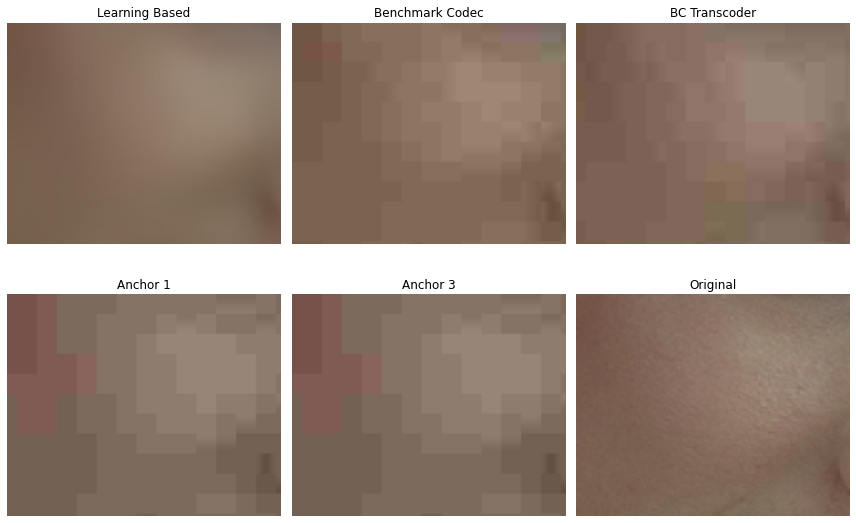

In [87]:
images = [img_learningbased_skin, img_benchmarkcodec_skin, img_bctranscoder_skin, img_anchor1_skin, img_anchor3_skin, img_original_skin]
titles = ['Learning Based', 'Benchmark Codec', 'BC Transcoder', 'Anchor 1', 'Anchor 3', 'Original']


dif = np.array(img_anchor1_skin)-np.array(img_anchor3_skin)
dif = Image.fromarray(dif)
dif.show()

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Flatten the axes array to iterate over it easily
axes = axes.flatten()

# Iterate over the images and titles and plot them in the corresponding subplot
for i, (image, title) in enumerate(zip(images, titles)):
    axes[i].imshow(image)
    axes[i].set_title(title)
    axes[i].axis('off')
    

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


### Kodak image 8

In [88]:
img_learningbased, tensor_learningbased = get_decoded_tensor('kodak', 'learningbased', 8, 4)
dna_learningbased = get_dna('kodak', 'learningbased',8, 4)

img_benchmarkcodec, tensor_benchmarkcodec = get_decoded_tensor('kodak', 'benchmarkcodec', 8, 8)
dna_benchmarkcodec = get_dna('kodak', 'benchmarkcodec', 8, 8)

img_bctranscoder, tensor_bctranscoder = get_decoded_tensor('kodak', 'BCtranscoder', 8, 2)
dna_bctranscoder = get_dna('kodak', 'BCtranscoder', 8, 2)

img_anchor1, tensor_anchor1 = get_decoded_tensor('kodak', 'anchor1', 8, 1)
dna_anchor1 = get_dna('kodak', 'anchor1', 8, 1)

img_anchor3, tensor_anchor3 = get_decoded_tensor('kodak', 'anchor3', 8, 1)
dna_anchor3 = get_dna('kodak', 'anchor3', 8, 1)

img_original, tensor_original = get_original_tensor('kodak', 8)

print("Learning based rate :  rate = ", compute_bit_rate(img_learningbased, dna_learningbased))
print("Benchmark codec rate : ", compute_bit_rate(img_benchmarkcodec, dna_benchmarkcodec))
print("BC transcoder rate : ", compute_bit_rate(img_bctranscoder, dna_bctranscoder))
print("Anchor 1 rate : ", compute_bit_rate(img_anchor1, dna_anchor1))
print("Anchor 3 rate : ", compute_bit_rate(img_anchor3, dna_anchor3))

Learning based rate :  rate =  0.48279571533203125
Benchmark codec rate :  0.6409123738606771
BC transcoder rate :  0.5624186197916666
Anchor 1 rate :  0.5918528238932291
Anchor 3 rate :  0.5503387451171875


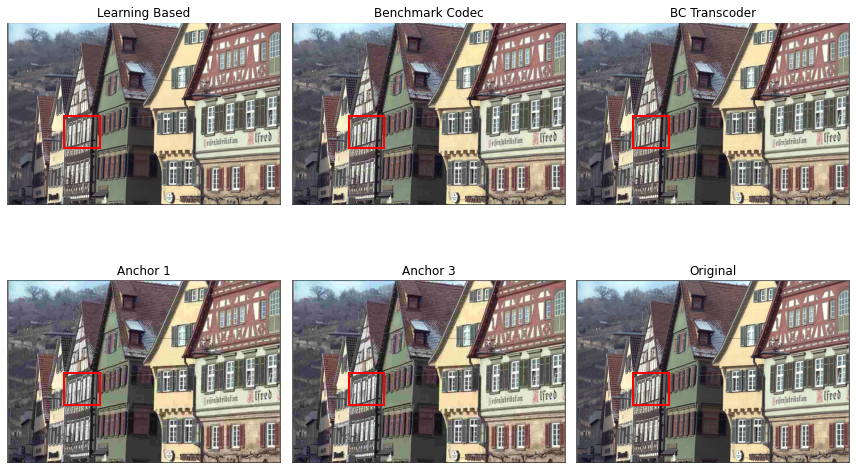

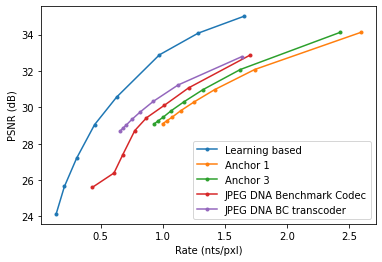

In [89]:
images = [img_learningbased, img_benchmarkcodec, img_bctranscoder, img_anchor1, img_anchor3, img_original]
titles = ['Learning Based', 'Benchmark Codec', 'BC Transcoder', 'Anchor 1', 'Anchor 3', 'Original']

box = (160, 260, 260, 350)

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Flatten the axes array to iterate over it easily
axes = axes.flatten()

# Iterate over the images and titles and plot them in the corresponding subplot
for i, (image, title) in enumerate(zip(images, titles)):
    axes[i].imshow(image)
    axes[i].set_title(title)
    axes[i].axis('off')
    
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                             linewidth=2, edgecolor='red', facecolor='none')
    axes[i].add_patch(rect)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

plot_metric('jpeg_dna', 'PSNR', 1)

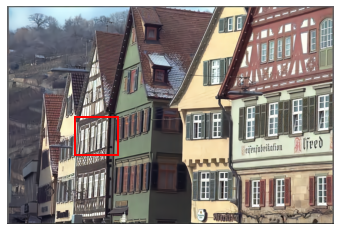

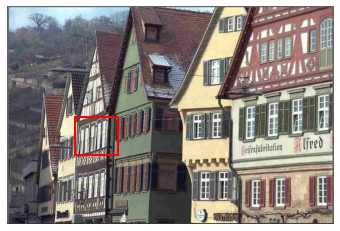

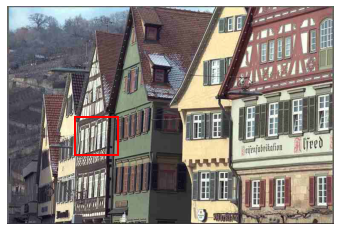

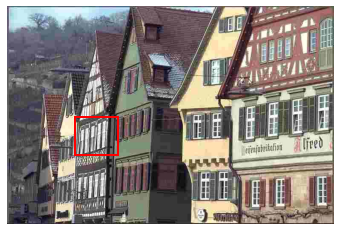

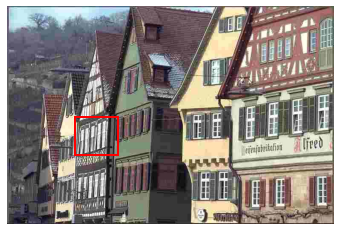

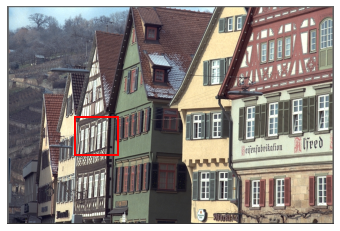

In [90]:
save_folder = '/Users/noemiemonnier/Documents/COURS/pds/CompressAI_pds/examples/assets/subjective eval/zoom/box'

for (img, title) in zip(images, titles):
    fig, ax = plt.subplots()  # Create a new figure and axes
    ax.imshow(img)
    ax.axis('off')

    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                             linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)  # Add the rectangle patch to the axes
    save_path = os.path.join(save_folder, f'{title}_box.png')
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

In [91]:
image_path = '/Users/noemiemonnier/Documents/COURS/pds/CompressAI_pds/examples/assets/subjective eval/zoom/'
box = (160, 260, 260, 350)
img_learningbased_zoom = img_learningbased.crop(box)
img_learningbased_zoom.save(f"{image_path}/lb.png")
img_benchmarkcodec_zoom = img_benchmarkcodec.crop(box)
img_benchmarkcodec_zoom.save(f"{image_path}/bc.png")
img_bctranscoder_zoom = img_bctranscoder.crop(box)
img_bctranscoder_zoom.save(f"{image_path}/bct.png")
img_anchor1_zoom = img_anchor1.crop(box)
img_anchor1_zoom.save(f"{image_path}/a1.png")
img_anchor3_zoom = img_anchor3.crop(box)
img_anchor3_zoom.save(f"{image_path}/a3.png")
img_original_zoom = img_original.crop(box)
img_original_zoom.save(f"{image_path}/og.png")

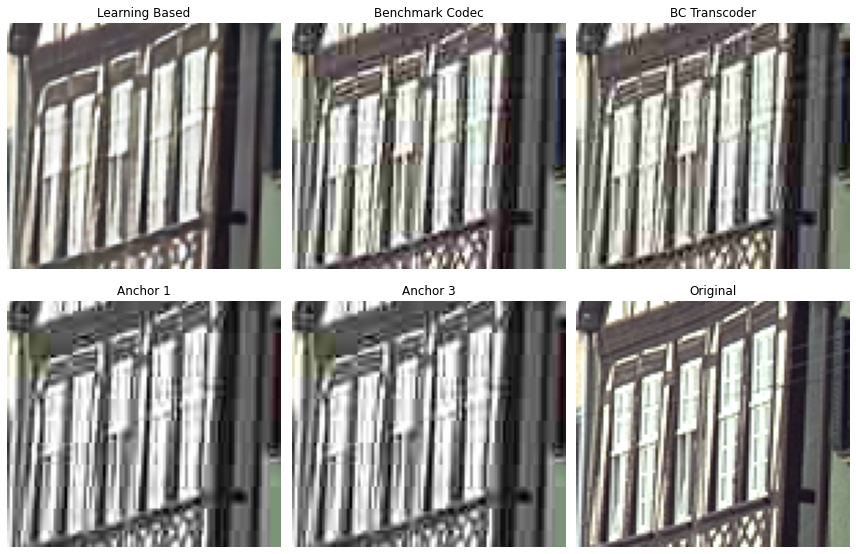

In [92]:
images = [img_learningbased_zoom, img_benchmarkcodec_zoom, img_bctranscoder_zoom, img_anchor1_zoom, img_anchor3_zoom, img_original_zoom]
titles = ['Learning Based', 'Benchmark Codec', 'BC Transcoder', 'Anchor 1', 'Anchor 3', 'Original']

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Flatten the axes array to iterate over it easily
axes = axes.flatten()

# Iterate over the images and titles and plot them in the corresponding subplot
for i, (image, title) in enumerate(zip(images, titles)):
    axes[i].imshow(image)
    axes[i].set_title(title)
    axes[i].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# Run time analysis


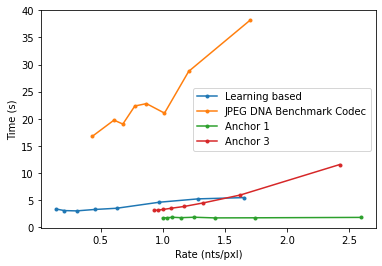

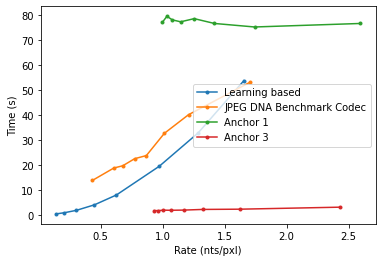

In [93]:
encode_times_learning_based = [
    3.3452579975128174,
    3.0539920330047607,
    2.998171806335449,
    3.2577340602874756,
    3.4842240810394287,
    4.598377227783203,
    5.217313051223755,
    5.452026128768921
]

decode_times_learning_based = [
    0.6236670017242432,
    1.0929291248321533,
    2.054450035095215,
    4.252428770065308,
    8.190752029418945,
    19.63059902191162, 
    32.905680894851685,
    53.82189726829529
]


encode_times_benchmark_codec = [
    38.17695903778076,
    28.740897178649902,
    21.040339946746826,
    22.791800022125244,
    22.351680040359497,
    19.019007205963135, 
    19.74818706512451,
    16.770718097686768
]

decode_times_benchmark_codec = [
    53.136662006378174,
    40.214035987854004,
    32.77933311462402, 
    23.89699912071228, 
    22.664918899536133, 
    19.823972940444946, 
    18.94500994682312, 
    13.965425968170166 
]

encode_times_anchor1 = [
    1.7966859340667725, 
    1.724107027053833, 
    1.7071609497070312, 
    1.8257699012756348, 
    1.7465341091156006, 
    1.8243398666381836, 
    1.7253992557525635, 
    1.7017719745635986
]

decode_times_anchor1 = [
    76.60408902168274, 
    75.20413994789124, 
    76.60886287689209, 
    78.53180861473083, 
    77.26843118667603, 
    78.04113626480103, 
    79.48708891868591, 
    77.10266423225403
]

encode_times_anchor3 = [
    11.553287744522095, 
    5.927840948104858, 
    4.4559009075164795, 
    3.8084659576416016, 
    3.489863872528076, 
    3.268483877182007, 
    3.1554131507873535, 
    3.0782270431518555
]

decode_times_anchor3 = [
    3.3123230934143066, 
    2.514108180999756, 
    2.4120898246765137, 
    2.1514599323272705, 
    2.0808210372924805, 
    2.1148221492767334, 
    1.9362680912017822, 
    1.9421491622924805
]
rates_learning_based = []
rates_anchor1 = []
rates_anchor3 = []
rates_benchmark_codec = []
for q in range(1,9): 
    dna_learning_based = get_dna('jpeg_dna', 'learningbased', 1, q)
    dna_benchmark_codec = get_dna('jpeg_dna', 'benchmarkcodec', 1, q)
    dna_anchor1 = get_dna('jpeg_dna', 'anchor1', 1, q)
    dna_anchor3 = get_dna('jpeg_dna', 'anchor3', 1, q)

    img, tens = get_original_tensor('jpeg_dna', 1)
    
    rates_learning_based.append(compute_bit_rate(img, dna_learning_based))
    rates_benchmark_codec.append(compute_bit_rate(img, dna_benchmark_codec))
    rates_anchor1.append(compute_bit_rate(img, dna_anchor1))
    rates_anchor3.append(compute_bit_rate(img, dna_anchor3))


plt.plot(rates_learning_based, encode_times_learning_based, label='Learning based', marker='o', markersize=3)
plt.plot(rates_benchmark_codec, encode_times_benchmark_codec, label='JPEG DNA Benchmark Codec', marker='o', markersize=3)
plt.plot(rates_anchor1, encode_times_anchor1, label='Anchor 1', marker='o', markersize=3)
plt.plot(rates_anchor3, encode_times_anchor3, label='Anchor 3', marker='o', markersize=3)

plt.xlabel('Rate (nts/pxl)')
plt.ylabel('Time (s)')
plt.legend()
plt.savefig('plots/Run times/encode.png', bbox_inches='tight')
plt.show()


plt.plot(rates_learning_based, decode_times_learning_based, label='Learning based', marker='o', markersize=3)
plt.plot(rates_benchmark_codec, decode_times_benchmark_codec, label='JPEG DNA Benchmark Codec', marker='o', markersize=3)
plt.plot(rates_anchor1, decode_times_anchor1, label='Anchor 1', marker='o', markersize=3)
plt.plot(rates_anchor3, decode_times_anchor3, label='Anchor 3', marker='o', markersize=3)


plt.xlabel('Rate (nts/pxl)')
plt.ylabel('Time (s)')
plt.legend()
plt.savefig('plots/Run times/decode.png', bbox_inches='tight')
plt.show()
#plt.title('Average ' + metric_name +' across the ' + data_set + ' data set for different models')


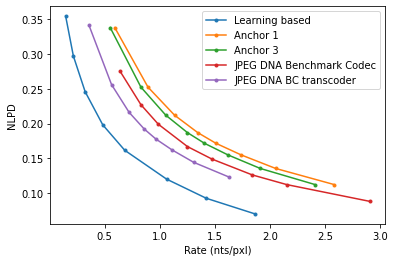

In [61]:
plot_metric('kodak', 'NLPD', 8)